In [36]:
!pip install networkx matplotlib pydot

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import re

In [38]:
def leer_gramatica(archivo):
    gramatica={}
    with open(archivo, 'r') as f:
        for linea in f:
            if '->' in linea:
                izquierda, derecha=linea.strip().split('->')
                produce=derecha.strip().split('|')
                for pro in produce:
                    gramatica.setdefault(izquierda.strip(), []).append(pro.strip().split())
    return gramatica

In [39]:
def tokenize(expr):
    tokens=[]
    i=0
    while i<len(expr):
        if expr[i].isspace():
            i+=1
        elif expr[i] in '+*()':
            tokens.append(expr[i])
            i+=1
        elif expr[i].isalpha():
            j=i
            while j<len(expr) and expr[j].isalpha():
                j+=1
            tokens.append(expr[i:j])
            i=j
        elif expr[i].isdigit():
            j=i
            while j<len(expr) and expr[j].isdigit():
                j+=1
            tokens.append(expr[i:j])
            i=j
        else:
            raise ValueError(f"Caracter inesperado: {expr[i]}")
    return tokens


In [40]:
class Parser:
    def __init__(self, tokens, gramatica):
        self.tokens=tokens
        self.pos=0
        self.id_nodo=0
        self.gramatica=gramatica
        self.G=nx.DiGraph()

    def nodo(self, label):
        _label=re.sub(r'[^a-zA-Z0-9_]', '_', label)
        nombre=f"{_label}_{self.id_nodo}"
        self.id_nodo+=1
        self.G.add_node(nombre, label=label)
        return nombre

    def mirar(self):
        return self.tokens[self.pos] if self.pos<len(self.tokens) else None

    def avance(self, expected=None):
        tok=self.mirar()
        if tok is None:
            return None
        if expected is not None and tok != expected:
            return None
        self.pos+=1
        return tok

    def parse(self):
        raiz=self.parse_noterminal('E')
        if raiz and self.pos==len(self.tokens):
            return raiz, self.G
        return None, None

    def parse_noterminal(self, simbolo):
        if simbolo not in self.gramatica:
            return None
        pos_guardada=self.pos
        padre_nodo=self.nodo(simbolo)

        for produccion in self.gramatica[simbolo]:
            nodos_hijos=[]
            self.pos=pos_guardada
            success=True
            if produccion==['ε'] or produccion==[]:
                nodo_vacio=self.nodo('ε')
                self.G.add_edge(padre_nodo, nodo_vacio)
                return padre_nodo

            for sim in produccion:
                if sim in self.gramatica:
                    nodo_hijo = self.parse_noterminal(sim)
                    if nodo_hijo is None:
                        success = False
                        break
                    nodos_hijos.append(nodo_hijo)
                else:
                    tok=self.mirar()
                    if tok is None:
                        success=False
                        break
                    if sim=='id' and tok.isalpha():
                        val_nodo=self.nodo(tok)
                        id_nodo=self.nodo("id")
                        self.G.add_edge(id_nodo, val_nodo)
                        nodos_hijos.append(id_nodo)
                        self.avance()
                    elif sim=='num' and tok.isdigit():
                        val_nodo=self.nodo(tok)
                        num_nodo=self.nodo("num")
                        self.G.add_edge(num_nodo, val_nodo)
                        nodos_hijos.append(num_nodo)
                        self.avance()
                    elif sim =='pari' and tok=='(':
                        val_nodo=self.nodo(tok)
                        pari_nodo=self.nodo("pari")
                        self.G.add_edge(pari_nodo, val_nodo)
                        nodos_hijos.append(pari_nodo)
                        self.avance()
                    elif sim=='pard' and tok==')':
                        val_nodo=self.nodo(tok)
                        pard_nodo=self.nodo("pard")
                        self.G.add_edge(pard_nodo, val_nodo)
                        nodos_hijos.append(pard_nodo)
                        self.avance()
                    elif sim in ('opsum', 'opmul') and tok in '+*':
                        if sim=='opsum' and tok=='+':
                            op_nodo=self.nodo("opsum")
                            val_nodo=self.nodo(tok)
                            self.G.add_edge(op_nodo, val_nodo)
                            nodos_hijos.append(op_nodo)
                            self.avance()
                        elif sim=='opmul' and tok=='*':
                            op_nodo=self.nodo("opmul")
                            val_nodo=self.nodo(tok)
                            self.G.add_edge(op_nodo, val_nodo)
                            nodos_hijos.append(op_nodo)
                            self.avance()
                        else:
                            success=False
                            break
                    else:
                        if tok==sim:
                            val_nodo=self.nodo(tok)
                            nodos_hijos.append(val_nodo)
                            self.avance()
                        else:
                            success = False
                            break

            if success:
                for hijo in nodos_hijos:
                    self.G.add_edge(padre_nodo, hijo)
                return padre_nodo
        return None

In [41]:
def hacer_arbol(G):
  pos=nx.nx_pydot.graphviz_layout(G, prog='dot')
  labels=nx.get_node_attributes(G, 'label')
  nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000, node_color='lightyellow', font_size=10, font_weight='bold')
  plt.show()

Ingresa una cadena de operacion: (2+3)*(5+3)


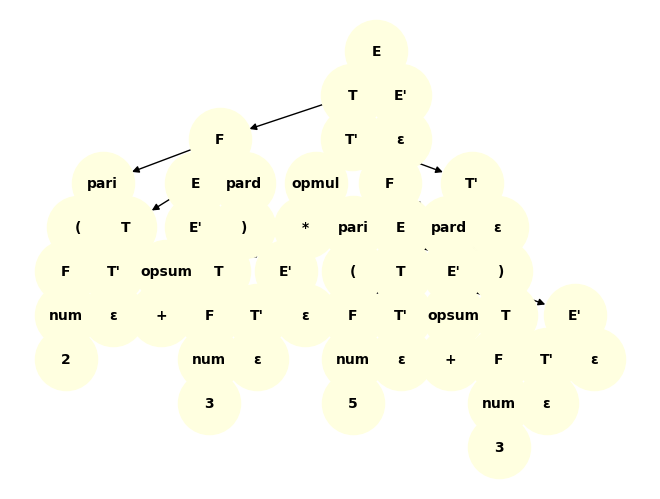

In [42]:
if __name__=="__main__":
  gramatica={
    "E": [["T", "E'"]],
    "E'": [["opsum", "T", "E'"], ["ε"]],
    "T": [["F", "T'"]],
    "T'": [["opmul", "F", "T'"], ["ε"]],
    "F": [["id"], ["num"], ["pari", "E", "pard"]],
}
  cadena=input("Ingresa una cadena de operacion: ")
  tokens=tokenize(cadena)
  p=Parser(tokens, gramatica)
  raiz, G=p.parse()

  if raiz is None or G is None:
    print("cadena NO aceptada")
  else:
    hacer_arbol(G)